# IMPORTING

In [1]:
import random
from datetime import date, datetime, timedelta
from numpy.random import choice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

# #0 EXPERIMENTING WITH MODELS

The heart of this randomly generated dataset is the source of traffic.<br>
The distribution of new users between different traffic sources (e.g. Facebook, Youtube, Google, etc.) changes over time -- and the underlying logic is that each data source has a different function that models its growth.<br>
E.g. Youtube grows following a 3rd degree polynomial, Insta is more like a log function, etc, etc.<br>
In this section, we test the perfect settings for these models -- before we actually start to use them for building our random dataset.

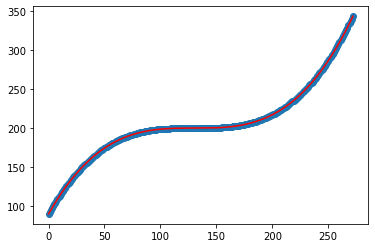

In [2]:
#YOUTUBE FUNCTION
x = []
y = []
for i in range(0,273,1):
    x.append(i)
    y.append(((((i)/10)-13) ** 3) / 20 + 200)

plt.scatter(x, y)
plt.plot(x, y, c = 'r')

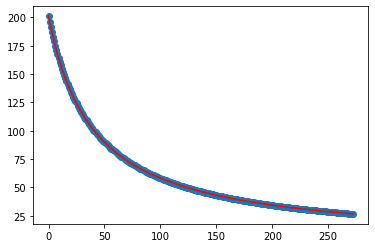

In [3]:
#FACEBOOK FUNCTION
x = []
y = []
for i in range(0,273,1):
    x.append(i)
    y.append((8000/(i + 40)) + 1)

plt.scatter(x, y)
plt.plot(x, y, c = 'r')

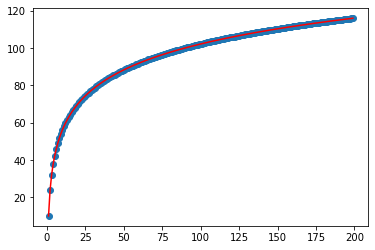

In [4]:
#INSTA FUNCTION
x = []
y = []
for i in range(1,200,1):
    x.append(i)
    y.append((math.log(i))*20 + 10)

plt.scatter(x, y)
plt.plot(x, y, c = 'r')

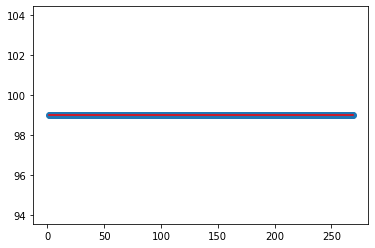

In [5]:
#REDDIT FUNCTION
x = []
y = []
for i in range(1,270,1):
    x.append(i)
    y.append((99))

plt.scatter(x, y)
plt.plot(x, y, c = 'r')

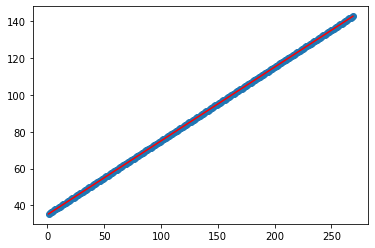

In [6]:
#GOOGLE ADS FUNCTION
x = []
y = []
for i in range(1,270,1):
    x.append(i)
    y.append(i*0.4 + 35)

plt.scatter(x, y)
plt.plot(x, y, c = 'r')

### All traffic sources aggregated:

In [7]:
x = []
y = []
youtube = []
facebook = []
insta = []
reddit = []
google_ads = []

for i in range(1,273):
    x.append(i)
    youtube_nu = ((((i)/10)-13) ** 3) / 20 + 200
    youtube.append(youtube_nu)
    facebook_nu = (4000/(i + 40)) + 1
    facebook.append(facebook_nu)
    insta_nu = (math.log(i))*20 + 10
    insta.append(insta_nu)
    reddit_nu = 54
    reddit.append(reddit_nu)
    google_ads_nu = i*0.3 + 35
    google_ads.append(google_ads_nu)
    y.append(youtube_nu + facebook_nu + insta_nu + reddit_nu + google_ads_nu)

In [8]:
y[0]

290.5265256097561

### The aggregated model using all traffic sources together:

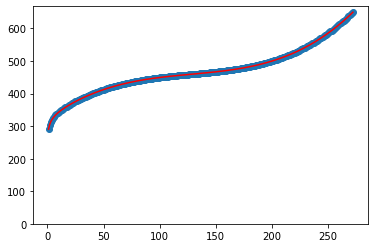

In [9]:
plt.scatter(x, y)
plt.ylim(ymin=0)
plt.plot(x, y, c = 'r')

# #1 BASIC PARAMETERS

Using the model from the previous section, we set the parameters that will generate the first readers.
<br>Additionally we set, how random the data can be (deviation from the original model).
<br>We also add extra parameters to generate the returning readers and the paying customers dataset.

In [10]:
#randomness factor
rand_min = -10
rand_max = 10

### First readers distribution

In [11]:
#TRAFFIC SOURCE DISTRIBUTION/PROBABILITIES
y = []
youtube = []
facebook = []
insta = []
reddit = []
google_ads = []
magnitude = 5 #how many times bigger is the dataset than the model (size of the data)

for i in range(1,300):
    youtube_nu = (((((i)/10)-13) ** 3) / 20 + 200) * magnitude
    youtube.append(youtube_nu)
    facebook_nu = ((4000/(i + 40)) + 1) * magnitude
    facebook.append(facebook_nu)
    insta_nu = ((math.log(i))*20 + 10) * magnitude
    insta.append(insta_nu)
    reddit_nu = (54) * magnitude
    reddit.append(reddit_nu)
    google_ads_nu = (i*0.3 + 35) * magnitude
    google_ads.append(google_ads_nu)

channels_first_readers = {'Youtube': youtube[0], 
                          'Facebook': facebook[0], 
                          'Insta': insta[0], 
                          'Reddit': reddit[0], 
                          'GoogleAds': google_ads[0]}

#CONTINENT PROBABITLITES
continents = ['US', 'Asia', 'EU']
continent_prob = [0.2, 0.5, 0.3]

#DEVICE PROBABILITES
devices = ['phone', 'desktop', 'tablet']
device_prob_us = [0.3, 0.1, 0.6]
device_prob_asia = [0.7, 0.2, 0.1]
device_prob_eu = [0.3, 0.5, 0.2]

#BROWSER PROBABILITES
browsers = ['chrome', 'firefox', 'other']
browser_probs_phone = [0.1, 0.1, 0.8]
browser_probs_tablet = [0.2, 0.1, 0.7]
browser_probs_desktop = [0.7, 0.2, 0.1]

### Returning users distribution

In [12]:
#returning -- if users return and they come from another source, what's the chance of each given source
channels = ['Youtube', 'Facebook', 'Insta', 'Reddit', 'GoogleAds']
channel_change_prob = [0.1, 0.5, 0.1, 0, 0.3]

### Paying customers distribution

In [13]:
#'x' shows a parameter that I used in the initial version of the script but not anymore

#come, return, buy probability distributions by traffic sources (aka. marketing channels)
marketing_weights = {
    'Youtube': ['x', 4, 8],
    'Facebook': ['x', 9, 3],
    'Insta': ['x', 3, 1],
    'Reddit': ['x', 3, 5],
    'GoogleAds': ['x', 6, 4]
}

#return, buy probability distributions by continents
continent_weights = {
    'US': [3, 6],
    'Asia': [5, 4],
    'EU': [2, 1]
}

#return, buy probability distributions by device types
device_weights = {
    'phone': [1, 2],
    'desktop': [2, 7],
    'tablet': [1, 3]
}

#return, buy probability distributions by browsers
browser_weights = {
    'chrome': ['x', 3],
    'firefox': ['x', 2],
    'other': ['x', 1]
}

# #2 LET'S GENERATE THE DATA!

Here's the core element of this project: the actual random generator.
<br>It factors in all parameters that we defined at the "BASIC PARAMETERS" section.
<br>It's quite a complex algorithm -- but it has 3 main steps (that build on each other):<br>
1) Generating the new/first readers dataset<br>
2) Generating the returning readers dataset<br>
3) Generating the paying customers dataset<br>
<br>
It tries to follow the logic of a real e-commerce business' funnel.

In [14]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [15]:
start_date = date(2019, 2, 1)
end_date = date(2019, 11, 1)
daily_users = []
x = 0

#how many users for how many days can return
return_window = 20 #days
returner_ratio = 0.05 #percentage_value

#how many users for how many days can buy
buy_window = 10 #days
base_buy_ratio = 0.006

#those who buy, what's the distribution between big, medium and small basket sizes
small_buy_ratio = 0.6 * base_buy_ratio
medium_buy_ratio = 0.3 * base_buy_ratio
big_buy_ratio = 0.1 * base_buy_ratio

#base parameters
log = []
first_user_id = 100000000
last_user_id = first_user_id
user_chances = {}
user_meta_data = {}
#{user_id: channel, continent, article_reads, last_apparance, last_device, subscribed, bought1, bought2, hater, first_apparance}

#ITERATING THROUGH DAYS
for single_date in daterange(start_date, end_date):
    
    daily_users.append([])
    
    #WEEKEND FACTOR
    if single_date.weekday() > 4:
        weekend_multiplier = 0.85
    else:
        weekend_multiplier = 1
        
    #######################
    #DISTRIBUTING THE USERS
    ####################### 
    random_value = 1 + random.randint(rand_min, rand_max) / 100
    
    channels_first_readers = {'Youtube': int(youtube[x] * weekend_multiplier * random_value), 
                          'Facebook': int(facebook[x] * weekend_multiplier * random_value), 
                          'Insta': int(insta[x] * weekend_multiplier * random_value), 
                          'Reddit': int(reddit[x] * weekend_multiplier * random_value), 
                          'GoogleAds': int(google_ads[x] * weekend_multiplier * random_value)}

    ############
    #NEW_READERS
    ############
    new_readers = []
    for channel in channels_first_readers:
        datelist = []
        for i in range(0, channels_first_readers[channel]):
            hour = random.randint(0, 23)
            minute = random.randint(0, 59)
            second = random.randint(0, 59)
            year = single_date.year
            month = single_date.month
            day = single_date.day
            actual_date = datetime(year, month, day, hour, minute, second)
            new_readers.append([actual_date, 'first_visit', channel])
    new_readers.sort()
    
    #FILLING UP WITH USER_ID'S & SOURCES
    user_id = last_user_id

    for i in new_readers:
        daily_users[x].append(user_id)
        
        i.append(user_id)
        user_meta_data[user_id] = [0, 0, 0, 0, 0, False, False, False, False, 0, 0]
        channel = i[2]
        user_meta_data[user_id][0] = channel
        
        #Generating continent data for user
        continent = choice(continents, 1, p = continent_prob)[0]
        i.append(continent)
        
        #Generating device data for user
        if continent == 'US':
            device_prob = device_prob_us
        elif continent == 'Asia':
            device_prob = device_prob_asia
        elif continent == 'EU':
            device_prob = device_prob_eu
        device = choice(devices, 1, p = device_prob)[0]
        i.append(device)
        
        #Generating browser type data for user
        if device == 'phone':
            browser_prob = browser_probs_phone
        elif device == 'tablet':
            browser_prob = browser_probs_tablet
        elif device == 'desktop':
            browser_prob = browser_probs_desktop
        browser = choice(browsers, 1, p = browser_prob)[0]
        i.append(browser)
        
        user_meta_data[user_id][1] = continent
        user_meta_data[user_id][2] = 1
        user_meta_data[user_id][3] = i[0]
        user_meta_data[user_id][9] = i[0]
        user_meta_data[user_id][4] = device
        user_meta_data[user_id][10] = browser

        i[0] = i[0].strftime('%Y-%m-%d %H:%M:%S')

        #Generating return probability data for user
        #user_chances = [return, buy]
        user_chances[user_id] = [0, 0]
        random_value = 1 + random.randint(rand_min, rand_max) / 100
        channel_chance = marketing_weights[channel][1]
        continent_chance = continent_weights[continent][0]
        device_chance = device_weights[device][0]
        return_chance = random_value * (channel_chance + continent_chance + device_chance)
        user_chances[user_id][0] = return_chance

        user_id = user_id + 1
    
    log.extend(new_readers)
    last_user_id = user_id
    
    ##########
    #RETURNERS
    ##########
    return_log = []
    
    for iteration_x in range(1,2):
        #only last x days users can return (x is defined in "return_window")
        if x - return_window >= 0:
            start_last_x = x - return_window
        else:
            start_last_x = 0
        
        last_x_users=[]
        for f in daily_users[start_last_x:(x+1)]:
            last_x_users = last_x_users + f
        
        #CALCULATING THE NUMBER OF RETURNING USERS FOR THE GIVEN DAY
        number_of_returners = int(returner_ratio * len(last_x_users) * (1 + random.randint(rand_min, rand_max) / 100) * weekend_multiplier)
        returning_chances = []
        for i in last_x_users:
            
            #after buying less interested to return
            if user_meta_data[i][5] == True:
                already_bought = 0.3
                user_chances[i][0] = user_chances[i][0] * already_bought
            else:
                already_bought = 1
        
            returning_chances.append(user_chances[i][0])
            
        the_cut = sorted(returning_chances, reverse=True)[number_of_returners]
        
        #PICKING THE USERS WHO ARE ABOVE THE "CUT" AND RETURN
        for i in last_x_users:
            if user_chances[i][0] >= the_cut and random.choice([True, True, False]):
                last_apparance = user_meta_data[i][3]
                if last_apparance.date() >= actual_date.date():
                    return_random = (1 + random.randint(-99, 260) / 100)
                    return_date = last_apparance + timedelta(seconds = 6000 * return_random)
                else:
                    hour = random.randint(0, 23)
                    minute = random.randint(0, 59)
                    second = random.randint(0, 59)
                    return_date = datetime(year, month, day, hour, minute, second)            
                user_meta_data[i][3] = return_date

                channel_change = random.choice([True, False, False, False, False])
                if channel_change:
                    channel = choice(channels, 1, p = channel_change_prob)[0]
                    user_meta_data[i][0] = channel
                user_meta_data[i][2] = user_meta_data[i][2] + 1
                continent = user_meta_data[i][1]
                device = user_meta_data[i][4]
                browser = user_meta_data[i][10]
                log.append([return_date.strftime('%Y-%m-%d %H:%M:%S'), "returning_visit", user_meta_data[i][0], i, continent, device, browser])
                return_log.append([return_date.strftime('%Y-%m-%d %H:%M:%S'), "returning_visit", user_meta_data[i][0], i, continent, device, browser])
                
                #SETTING A FEW USERS RANDOMLY WHO DECIDE TO "HATE" THE WEBSITE
                hater = random.choice([True, False, False, False, False, False])
                if hater:
                    user_chances[i][0] = 0
                    user_meta_data[i][8] = True

    #######
    #BUYERS
    #######
    small_buy_log = []
        
    #only last x days users can buy (x is defined by the "buy_window" parameter)
    if x - buy_window >= 0:
        start_last_x = x - buy_window
    else:
        start_last_x = 0
        
    last_x_users = []
    for f in daily_users[start_last_x:(x+1)]:
        last_x_users = last_x_users + f

    #CALCULATING THE NUMBER OF PAYING CUSTOMERS FOR THE GIVEN DAY (BY BASKET SIZE)
    number_of_small_buys = int((small_buy_ratio + medium_buy_ratio + big_buy_ratio) * len(last_x_users) * (1 + random.randint(rand_min, rand_max) / 100))
    number_of_medium_buys = int((medium_buy_ratio + big_buy_ratio) * len(last_x_users) * (1 + random.randint(rand_min, rand_max) / 100))
    number_of_big_buys = int(big_buy_ratio * len(last_x_users) * (1 + random.randint(rand_min, rand_max) / 100))

    buying_chances = []
    for i in last_x_users:
        
        #only one buy per user
        if user_meta_data[i][5] == True:
            already_bought = 0
        else:
            already_bought = 1
        
        random_value = 1 + random.randint(rand_min, rand_max) / 100
        channel_chance = marketing_weights[channel][2]
        continent_chance = continent_weights[continent][1]
        device_chance = device_weights[device][1]
        browser_chance = browser_weights[browser][1]
        visit_chance = user_meta_data[i][2]
        small_buy_chance = random_value * (channel_chance + continent_chance + device_chance + browser_chance + visit_chance) * already_bought
        user_chances[i][1] = small_buy_chance    

        buying_chances.append(user_chances[i][1])
        
    small_buy_cut = sorted(buying_chances, reverse=True)[number_of_small_buys]
    medium_buy_cut = sorted(buying_chances, reverse=True)[number_of_medium_buys]
    big_buy_cut = sorted(buying_chances, reverse=True)[number_of_big_buys]

    #PICKING THE USERS WHO ARE ABOVE THE "CUTs" AND BUY
    for i in last_x_users:
        if user_chances[i][1] >= small_buy_cut:
            first_apparance = user_meta_data[i][9]
            last_apparance = user_meta_data[i][3]

            if first_apparance.date() >= actual_date.date():
                small_buy_random = (1 + random.randint(0, rand_max) / 100)
                if random.choice([True, False]):
                    small_buy_date = first_apparance + timedelta(seconds = 100 * small_buy_random)
                else:
                    small_buy_date = last_apparance + timedelta(seconds = 100 * small_buy_random)
            else:
                hour = random.randint(0, 23)
                minute = random.randint(0, 59)
                second = random.randint(0, 59)
                small_buy_date = datetime(year, month, day, hour, minute, second)            
            
            return_date = small_buy_date - timedelta(seconds = 300 * (1 + random.randint(-50, 50) / 100))
            
            channel_change = random.choice([True, False, False, False, False])
            if channel_change:
                channel = choice(channels, 1, p = channel_change_prob)[0]
                user_meta_data[i][0] = channel

            channel = user_meta_data[i][0]
            continent = user_meta_data[i][1]
            device = user_meta_data[i][4]
            browser = user_meta_data[i][10]
            log.append([return_date.strftime('%Y-%m-%d %H:%M:%S'), "returning_visit", channel, i, continent, device, browser])
            if user_chances[i][1] >= big_buy_cut:
                buy_amount = random.randint(6,10)
                purchase_size = "big"
            elif user_chances[i][1] < big_buy_cut and user_chances[i][1] >= medium_buy_cut:
                buy_amount = random.randint(3,5)
                purchase_size = "medium"
            elif user_chances[i][1] < medium_buy_cut and user_chances[i][1] >= small_buy_cut:
                buy_amount = random.randint(1,2)
                purchase_size = "small"
                
            log.append([small_buy_date.strftime('%Y-%m-%d %H:%M:%S'), "purchase", "-", i, purchase_size, buy_amount])
            user_meta_data[i][5] = True

    x = x + 1

log.sort()

# THE RESULT

In [16]:
log[0]

['2019-02-01 00:00:07',
 'first_visit',
 'Reddit',
 100000000,
 'US',
 'tablet',
 'other']

In [17]:
result = pd.DataFrame(log, columns = ['datetime', 'action', 'channel', 'user_id', 'continent', 'device', 'browser'])

In [18]:
result.sample(10)

,datetime,action,channel,user_id,continent,device,browser
669843,2019-08-01 10:17:40,returning_visit,Facebook,100325328,Asia,desktop,other
512523,2019-06-24 12:06:27,returning_visit,GoogleAds,100251481,Asia,phone,other
1063846,2019-10-24 03:52:26,returning_visit,Facebook,100574138,Asia,tablet,firefox
988480,2019-10-10 00:56:08,first_visit,Reddit,100545351,Asia,phone,other
865273,2019-09-14 16:18:23,purchase,-,100450907,small,2,None
908303,2019-09-23 17:13:18,first_visit,GoogleAds,100501180,Asia,tablet,other
724014,2019-08-14 01:42:59,returning_visit,Facebook,100392003,Asia,desktop,firefox
607561,2019-07-17 21:50:59,first_visit,GoogleAds,100337327,EU,desktop,firefox
1052789,2019-10-22 07:12:43,returning_visit,GoogleAds,100577200,Asia,phone,other
1100407,2019-10-31 00:16:29,first_visit,GoogleAds,100606835,Asia,desktop,firefox


In [19]:
result.tail()

,datetime,action,channel,user_id,continent,device,browser
1106023,2019-11-01 04:04:32,returning_visit,GoogleAds,100609674,Asia,phone,other
1106024,2019-11-01 04:28:25,returning_visit,Youtube,100609899,Asia,desktop,other
1106025,2019-11-01 04:41:49,returning_visit,Youtube,100609864,Asia,desktop,other
1106026,2019-11-01 05:13:58,returning_visit,GoogleAds,100609856,Asia,phone,firefox
1106027,2019-11-01 05:32:21,returning_visit,Insta,100609890,Asia,phone,other


# EXPORT TO CSV

In [ ]:
result_table = result_table[result_table.datetime < '2019-11-01']
first_visit = result_table[result_table.action == 'first_visit']
returning_visit = result_table[result_table.action == 'returning_visit']
purchase = result_table[result_table.action == 'purchase']

first_visit.to_csv('first_visit.csv', sep=';', header=False, index=False)
returning_visit.to_csv('returning_visit.csv', sep=';', header=False, index=False)
purchase.to_csv('purchase.csv', sep=';', header=False, index=False)

# =========================
# |    AND A FEW TEST ANALYSES       |
# =========================

to see what we have created

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

In [21]:
test = pd.DataFrame(log, columns = ['datetime', 'action', 'channel', 'user_id', 'continent', 'device', 'browser'])

In [22]:
test = test[test.datetime < '2019-11-01']
test

,datetime,action,channel,user_id,continent,device,browser
0,2019-02-01 00:00:07,first_visit,Reddit,100000000,US,tablet,other
1,2019-02-01 00:00:28,first_visit,Facebook,100000001,US,tablet,other
2,2019-02-01 00:00:55,first_visit,Facebook,100000002,EU,desktop,chrome
3,2019-02-01 00:01:13,first_visit,Reddit,100000003,Asia,phone,other
4,2019-02-01 00:02:17,first_visit,Youtube,100000004,US,phone,other
...,...,...,...,...,...,...,...
1105972,2019-10-31 23:59:15,first_visit,Insta,100609902,Asia,phone,other
1105973,2019-10-31 23:59:18,first_visit,Youtube,100609903,US,phone,other
1105974,2019-10-31 23:59:28,first_visit,GoogleAds,100609904,US,tablet,other
1105975,2019-10-31 23:59:37,returning_visit,GoogleAds,100586937,Asia,desktop,chrome


In [23]:
firstr = test[test.action == 'first_visit']
rr = test[test.action == 'returning_visit']
buy = test[test.action == 'purchase']

In [25]:
firstr[['my_date', 'my_time']] = firstr.datetime.str.split(" ", expand = True)
rr[['my_date', 'my_time']] = rr.datetime.str.split(" ", expand = True)
buy[['my_date', 'my_time']] = buy.datetime.str.split(" ", expand = True)
buy.columns = ['datetime', 'action', 'channel', 'user_id', 'buy_size', 'basket_size', 'empty', 'my_date', 'my_time']
buy['basket_size'] = pd.to_numeric(buy['basket_size'])

<ipython-input-25-095d7d220a93>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy['basket_size'] = pd.to_numeric(buy['basket_size'])


In [26]:
firstr.count()[0], rr.count()[0], buy.count()[0]

(609906, 454575, 41496)

(0.0, 3437.3)

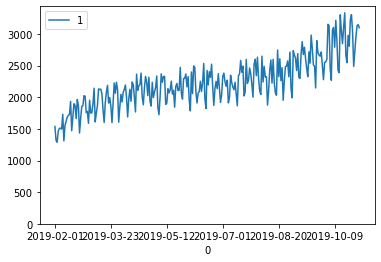

In [27]:
firstr.datetime.str.split(" ", expand = True).groupby(0).count().plot().set_ylim(ymin=0)

(0.0, 3121.7)

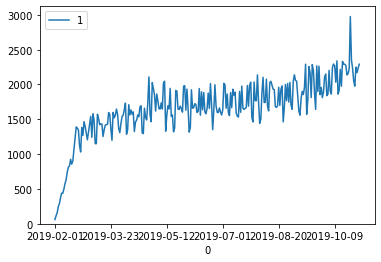

In [28]:
rr.datetime.str.split(" ", expand = True).groupby(0).count().plot().set_ylim(ymin=0)

<AxesSubplot:xlabel='my_date'>

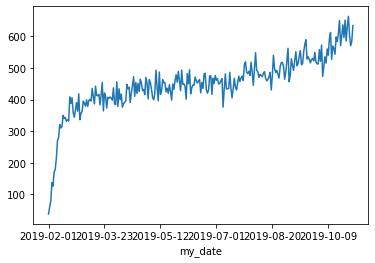

In [29]:
buy.groupby('my_date').sum().basket_size.plot()

(0.0, 243.1)

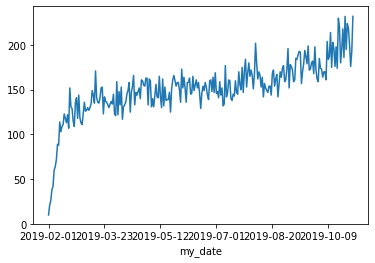

In [30]:
buy.groupby('my_date').count().basket_size.plot().set_ylim(ymin=0)

<AxesSubplot:xlabel='channel'>

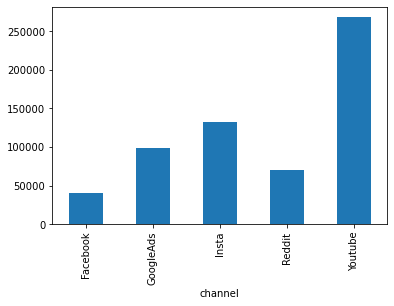

In [39]:
firstr.groupby('channel')['datetime'].count().plot.bar()

<AxesSubplot:xlabel='channel'>

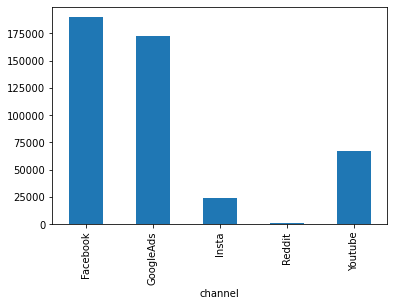

In [38]:
rr.groupby('channel')['datetime'].count().plot.bar()

In [41]:
firstr[(firstr.channel == 'Youtube') | (firstr.channel == 'Facebook')
      ].groupby(['my_date', 'channel']).count().user_id

my_date     channel 
2019-02-01  Facebook     522
            Youtube      491
2019-02-02  Facebook     417
            Youtube      412
2019-02-03  Facebook     387
                        ... 
2019-10-29  Youtube     1649
2019-10-30  Facebook      67
            Youtube     1664
2019-10-31  Facebook      65
            Youtube     1644
Name: user_id, Length: 546, dtype: int64